Loading and preprocessing data...
Loaded 3193 images and 3193 height arrays.
Extracting HOG features...
Training set size: 2554, Test set size: 639
Classes of the test data: [[0.25982723 0.25976925 0.25449327 ... 0.25860969 0.27237941 0.27437964]
 [0.38998724 0.39091489 0.38943646 ... 0.3104128  0.30925325 0.31116651]
 [0.23237477 0.23043251 0.22869318 ... 0.13613173 0.12844968 0.09914193]
 ...
 [0.26208836 0.26397263 0.25927644 ... 0.25466721 0.25527597 0.25368159]
 [0.75492811 0.7453038  0.72721475 ... 0.72559137 0.73547658 0.74486897]
 [0.17451299 0.1726577  0.14546614 ... 0.16628015 0.1661352  0.16912106]]
Training fold 1...
Fold 1 - MSE: 0.0052, RMSE: 0.0722, MAE: 0.0539, R2: 0.7593
Training fold 2...
Fold 2 - MSE: 0.0050, RMSE: 0.0707, MAE: 0.0519, R2: 0.7614
Training fold 3...
Fold 3 - MSE: 0.0051, RMSE: 0.0712, MAE: 0.0520, R2: 0.7841
Training fold 4...
Fold 4 - MSE: 0.0053, RMSE: 0.0729, MAE: 0.0536, R2: 0.7602
Training fold 5...
Fold 5 - MSE: 0.0060, RMSE: 0.0774, MAE: 0.0546

/tmp/ipykernel_6776/2852288242.py:243: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


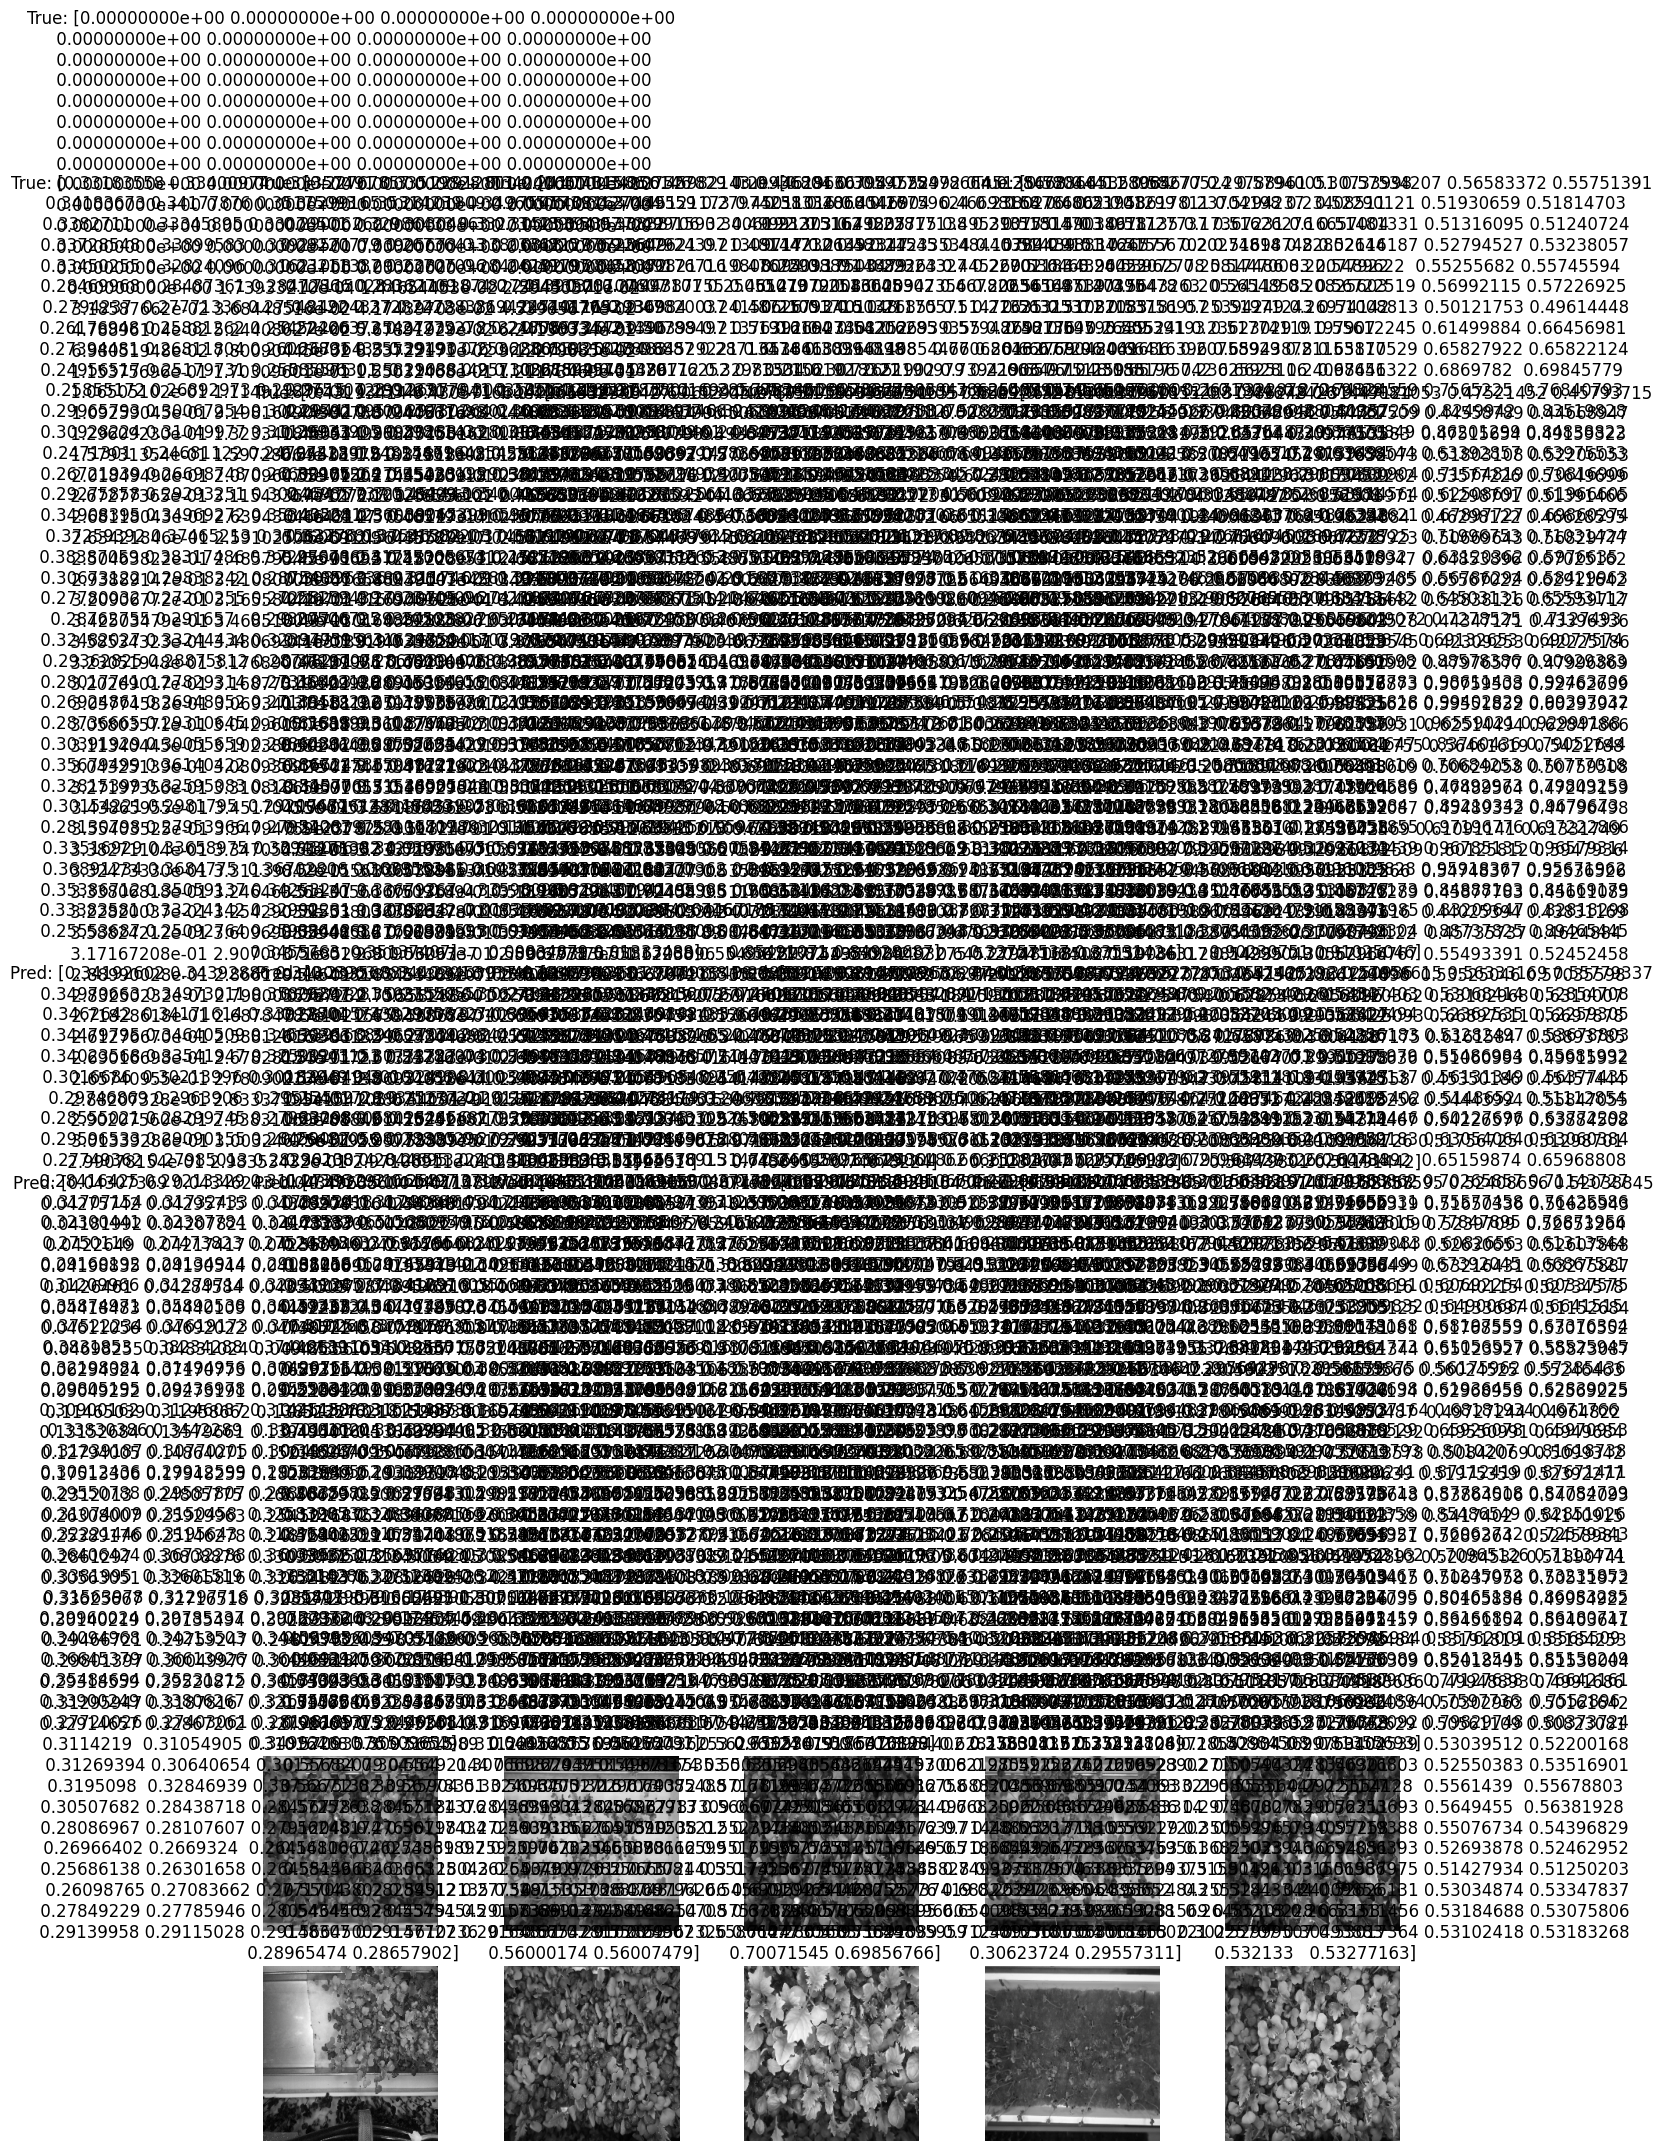

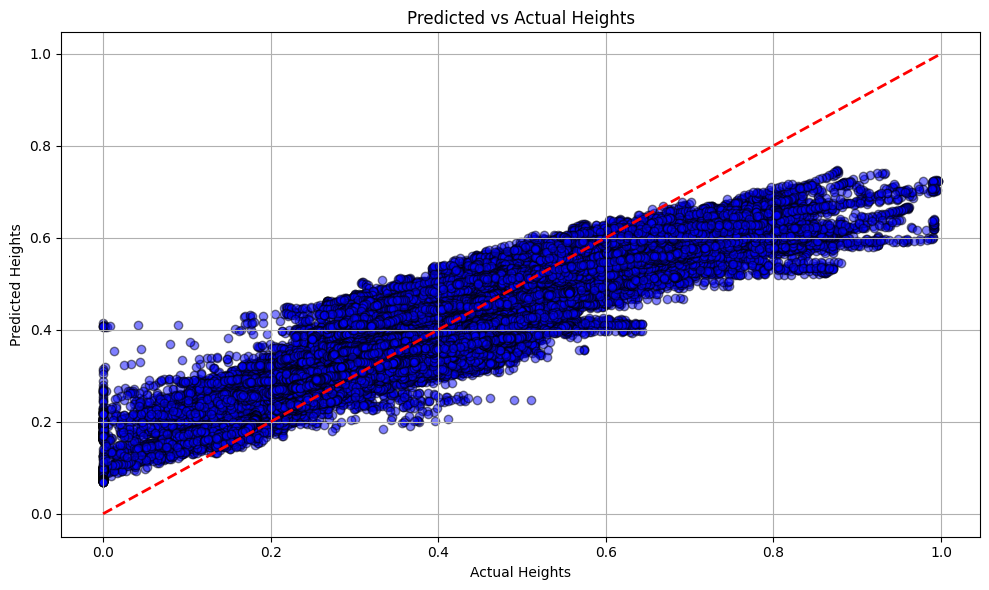

In [3]:
# full (224-segments) model with 5-fold cv, train and validation loss plots, saving of test results

import os
import numpy as np
import cv2
import pandas as pd
import json
from skimage.feature import hog
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from skimage import exposure
from tqdm import tqdm
import concurrent.futures
import pickle
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Paths to the folders containing the images and height arrays
image_folder = 'bright_spicy_2024/CNN_top_images'
height_folder = 'bright_spicy_2024/CNN_height_arrays'
csv_path = 'CNN_input.csv'
model_save_path = 'RF_full_hp_top_model_NO_TRIM.pkl'
results_save_path = 'RF_results/full_top_RF_results_NO_TRIM.csv'
plot_save_path = 'RF_results/full_top_RF_cv_plot_NO_TRIM.png'
test_results_path = 'RF_results/full_top_RF_test_results_NO_TRIM.json'
metrics_save_path = 'RF_results/full_top_RF_metrics_NO_TRIM.json'

# Best hyperparameters
best_params = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'trim_bottom': 0.0,
    'trim_top': 0.0,
}

def load_image_and_height(height_file, top_image_name, image_folder, height_folder):
    height_path = os.path.join(height_folder, height_file + '.npy')
    img_path = os.path.join(image_folder, top_image_name)

    if not os.path.exists(img_path):
        print(f"Image file does not exist: {img_path}")
        return None, None

    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image: {img_path}")
        return None, None
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Rotate the image 180 degrees
    img = cv2.rotate(img, cv2.ROTATE_180)

    height, width = img.shape[:2]
    start_x = (width - 3280) // 2
    start_y = (height - 2464) // 2
    img = img[start_y:start_y + 2464, start_x:start_x + 3280]  # Symmetric crop
    img = cv2.resize(img, (224, 224))

    height_array = np.load(height_path)
    if height_array.size == 0:
        print(f"Height array is empty: {height_path}")
        return None, None

    # Normalize the height array based on the total possible height (2464)
    normalized_height_array = height_array / 2464.0

    # Divide height array into 224 pieces and calculate the average of each piece
    height_segment_length = len(normalized_height_array) // 224
    avg_height_per_segment = np.array([
        np.mean(normalized_height_array[i*height_segment_length:(i+1)*height_segment_length])
        for i in range(224)
    ])

    return img, avg_height_per_segment


def preprocess_data(height_files, top_images, image_folder, height_folder):
    images, height_arrays = [], []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(load_image_and_height, height_files, top_images, [image_folder]*len(height_files), [height_folder]*len(height_files)))
    for img, height_array in results:
        if img is not None and height_array is not None:
            images.append(img)
            height_arrays.append(height_array)
    return np.array(images), np.array(height_arrays)

def custom_preprocessing(img):
    img = np.array(img)
    for channel in range(img.shape[2]):
        img[..., channel] = exposure.rescale_intensity(img[..., channel], out_range=(0, 1))
        img[..., channel] = exposure.equalize_hist(img[..., channel])
        img[..., channel] = exposure.equalize_adapthist(img[..., channel], clip_limit=0.03)
    return img

# Load the CSV file to match height arrays with top images
csv_data = pd.read_csv(csv_path)
height_files = csv_data.iloc[:, 0].tolist()
top_images = csv_data.iloc[:, 1].tolist()

print("Loading and preprocessing data...")
images, height_arrays = preprocess_data(height_files, top_images, image_folder, height_folder)
if len(images) == 0 or len(height_arrays) == 0:
    raise ValueError("No images or height arrays were loaded. Please check the data folder and files.")

images = images / 255.0

print(f"Loaded {len(images)} images and {len(height_arrays)} height arrays.")

# Extract HOG features
def extract_hog_features(image):
    gray_image = (image * 255).astype(np.uint8)  # Convert to 8-bit unsigned integer
    gray_image = cv2.cvtColor(gray_image, cv2.COLOR_RGB2GRAY)
    fd, hog_image = hog(gray_image, orientations=8, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1), visualize=True)
    return fd, hog_image

print("Extracting HOG features...")
hog_features, hog_images = zip(*[extract_hog_features(img) for img in images])
hog_features = np.array(hog_features)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(hog_features, height_arrays, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")
print(f"Classes of the test data: {y_test}")

# 5-fold cross-validation setup on training data
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
cv_results = []
fold_metrics = []

for train_index, val_index in kf.split(X_train):
    print(f"Training fold {fold}...")
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    
    model = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=42
    )

    model.fit(X_train_cv, y_train_cv)
    y_pred_val = model.predict(X_val_cv)
    mse_val = mean_squared_error(y_val_cv, y_pred_val)
    rmse_val = np.sqrt(mse_val)
    mae_val = mean_absolute_error(y_val_cv, y_pred_val)
    r2_val = r2_score(y_val_cv, y_pred_val)

    fold_results = {
        'fold': fold,
        'mse': mse_val,
        'rmse': rmse_val,
        'mae': mae_val,
        'r2': r2_val
    }
    
    cv_results.append(mse_val)
    fold_metrics.append(fold_results)
    
    print(f"Fold {fold} - MSE: {mse_val:.4f}, RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R2: {r2_val:.4f}")
    fold += 1

mean_cv_mse = np.mean(cv_results)
print(f"Mean cross-validation MSE: {mean_cv_mse:.4f}")

# Save cross-validation results
cv_results_dict = {
    'fold_mse': cv_results,
    'mean_cv_mse': mean_cv_mse
}
pd.DataFrame(cv_results_dict).to_csv(results_save_path, index=False)

# Save fold metrics
with open(results_save_path.replace('.csv', '_detailed.json'), 'w') as f:
    json.dump(fold_metrics, f)

# Fit final model on all training data
print("Training final model on all training data...")
final_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
final_model.fit(X_train, y_train)

# Save the model
with open(model_save_path, 'wb') as f:
    pickle.dump(final_model, f)
print(f"Model saved to {model_save_path}")

# Evaluate the final model on the test set
y_pred_test = final_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f'Test set MSE: {mse_test:.4f}')
print(f'Test set RMSE: {rmse_test:.4f}')
print(f'Test set MAE: {mae_test:.4f}')
print(f'Test set R2: {r2_test:.4f}')

# Save metrics
metrics_dict = {
    'mse_test': mse_test,
    'rmse_test': rmse_test,
    'mae_test': mae_test,
    'r2_test': r2_test
}
with open(metrics_save_path, 'w') as f:
    json.dump(metrics_dict, f)

# Save prediction results
test_results_dict = {
    'y_test': y_test.tolist(),
    'y_pred_test': y_pred_test.tolist()
}
with open(test_results_path, 'w') as f:
    json.dump(test_results_dict, f)

# Visualize some predictions
def visualize_predictions(images, true_heights, predicted_heights, num_samples=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        img = images[idx]
        true_height = true_heights[idx]
        predicted_height = predicted_heights[idx]
        plt.subplot(2, num_samples // 2, i+1)
        plt.imshow(cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY), cmap='gray')
        plt.title(f"True: {true_height}\nPred: {predicted_height}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(images, height_arrays, final_model.predict(hog_features), num_samples=10)

# Generate scatter plot
y_test_flat = y_test.flatten()
y_pred_test_flat = y_pred_test.flatten()

plt.figure(figsize=(10, 6))
plt.scatter(y_test_flat, y_pred_test_flat, alpha=0.5, color='b', edgecolors='k')
plt.title('Predicted vs Actual Heights')
plt.xlabel('Actual Heights')
plt.ylabel('Predicted Heights')
plt.plot([y_test_flat.min(), y_test_flat.max()], [y_test_flat.min(), y_test_flat.max()], color='red', linestyle='--', linewidth=2)  # Diagonal line
plt.grid(True)
plt.tight_layout()

# Save the plot to the specified path
scatter_plot_save_path = 'RF_results/full_top_RF_pred_vs_actual_scatter_plot_NO_TRIM.png'
plt.savefig(scatter_plot_save_path)

# Show the plot
plt.show()